# **Setup**

## 1.1 Install Packages

In [1]:
!pip install imbalanced-learn
!pip install -q transformers
!pip install black[jupyter]
!pip install "ray[tune]"

     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 47.2 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 6.6 MB 36.0 MB/s 
     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 843 kB 44.6 MB/s 
     |████████████████████████████████| 96 kB 5.3 MB/s 
     |████████████████████████████████| 793 kB 44.6 MB/s 
     |████████████████████████████████| 381 kB 45.9 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython

     |████████████████████████████████| 53.2 MB 209 kB/s 
     |████████████████████████████████| 144 kB 51.6 MB/s 
     |████████████████████████████████| 8.8 MB 31.7 MB/s 
     |████████████████████████████████| 4.1 MB 33.0 MB/s 
     |████████████████████████████████| 125 kB 47.6 MB/s 
     |████████████████████████████████| 461 kB 44.1 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.46.1
    Uninstalling grpcio-1.46.1:
      Successfully uninstalled grpcio-1.46.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


## 1.2 Import Libraries

In [2]:
# indonlu repository forked from https://github.com/indobenchmark/indonlu
!git clone https://github.com/ryzanugrah/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 475, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 475 (delta 115), reused 112 (delta 112), pack-reused 331
Receiving objects: 100% (475/475), 4.84 MiB | 10.43 MiB/s, done.
Resolving deltas: 100% (241/241), done.


In [3]:
import os
import pickle
import random

from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import torch
import torch.nn.functional as F
from google.colab import data_table, drive
from indonlu.utils.data_utils import (
    HateSpeechClassificationDataLoader,
    MultiLabelHateSpeechClassificationDataset,
)
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import multi_label_hate_speech_classification_metrics_fn
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from torch import optim
from tqdm import tqdm
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer, AdamW

## 1.3 Colab Configuration
You can ignore this section if you are not using Google Colab

In [4]:
# mount Drive
drive.mount("/content/drive")

# enable data table display (interactive table)
data_table.enable_dataframe_formatter()

Mounted at /content/drive


## 1.4 Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 GPU`

Then run the following cell to confirm that the GPU is detected.

In [5]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: Tesla K80


## 1.4 Set Random Seed

In [7]:
# common functions
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
    
# count number of parameters  
def count_param(module, trainable=False):
  if trainable:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)
  else:
    return sum(p.numel() for p in module.parameters())

# get the learning rate
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

# change from metrics evaluation to string
def metrics_to_string(metric_dict):
  string_list = []
  
  for key, value in metric_dict.items():
    string_list.append('{}:{:.2f}'.format(key, value))
  return ' '.join(string_list)

# set random seed
set_seed(6)
random_state=7 

In [8]:
# """
# This example is uses the official
# huggingface transformers `hyperparameter_search` API.
# """
# import os

# import psutil
# import ray
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.examples.pbt_transformers.utils import (
#     download_data,
#     build_compute_metrics_fn,
# )
# from ray.tune.schedulers import PopulationBasedTraining
# from transformers import (
#     glue_tasks_num_labels,
#     AutoConfig,
#     BertForSequenceClassification,
#     AutoTokenizer,
#     Trainer,
#     GlueDataset,
#     GlueDataTrainingArguments,
#     TrainingArguments,
# )


# def tune_transformer(num_samples=8, gpus_per_trial=0, smoke_test=False):
#     data_dir_name = "./data" if not smoke_test else "./test_data"
#     data_dir = os.path.abspath(os.path.join(os.getcwd(), data_dir_name))
#     if not os.path.exists(data_dir):
#         os.mkdir(data_dir, 0o755)

#     # Change these as needed.
#     model_name = (
#         "indobert-base-p1" if not smoke_test else "indobenchmark/indobert-base-p1"
#     )
#     task_name = "rte"

#     task_data_dir = os.path.join(data_dir, task_name.upper())

#     num_labels = glue_tasks_num_labels[task_name]

#     config = BertConfig.from_pretrained(model_name, num_labels=num_labels, finetuning_task=task_name)

#     # Download and cache tokenizer, model, and features
#     print("Downloading and caching Tokenizer")
#     tokenizer = BertTokenizer.from_pretrained(model_name)

#     # Triggers tokenizer download to cache
#     print("Downloading and caching pre-trained model")
#     BertForSequenceClassification.from_pretrained(
#         model_name,
#         config=config,
#     )

#     def get_model():
#         return BertForSequenceClassification.from_pretrained(
#             model_name,
#             config=config,
#         )

#     # Download data.
#     # download_data(task_name, data_dir)

#     train_dataset_path = 'dataset_training.csv'
#     test_dataset_path = 'dataset_testing.csv'
#     eval_dataset_path = 'dataset_validation.csv'

#     train_dataset = MultiLabelHateSpeechClassificationDataset(train_dataset_path, tokenizer, lowercase=True)
#     testing_dataset = MultiLabelHateSpeechClassificationDataset(test_dataset_path, tokenizer, lowercase=True)
#     eval_dataset = MultiLabelHateSpeechClassificationDataset(eval_dataset_path, tokenizer, lowercase=True)

#     training_args = TrainingArguments(
#         output_dir=".",
#         learning_rate=1e-5,  # config
#         do_train=True,
#         do_eval=True,
        
#         no_cuda=gpus_per_trial <= 0,
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         load_best_model_at_end=True,
#         num_train_epochs=2,  # config
#         max_steps=-1,
#         per_device_train_batch_size=16,  # config
#         per_device_eval_batch_size=16,  # config
#         warmup_steps=0,
#         weight_decay=0.1,  # config
#         logging_dir="logs",
#         skip_memory_metrics=True,
#         report_to="none",
#     )

#     trainer = Trainer(
#         model_init=get_model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=eval_dataset,
#         compute_metrics=build_compute_metrics_fn(task_name),
#     )

#     tune_config = {
#         "per_device_train_batch_size": 32,
#         "per_device_eval_batch_size": 32,
#         "num_train_epochs": tune.choice([2, 3, 4]),
#         "num_workers" : 1,
#         "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
#     }

#     scheduler = PopulationBasedTraining(
#         time_attr="training_iteration",
#         metric="eval_acc",
#         mode="max",
#         perturbation_interval=1,
#         hyperparam_mutations={
#             "weight_decay": tune.uniform(0.0, 0.3),
#             "learning_rate": tune.uniform(1e-5, 5e-5),
#             "per_device_train_batch_size": [16, 32],
#         },
#     )

#     reporter = CLIReporter(
#         parameter_columns={
#             "weight_decay": "w_decay",
#             "learning_rate": "lr",
#             "per_device_train_batch_size": "train_bs/gpu",
#             "num_train_epochs": "num_epochs",
#         },
#         metric_columns=["eval_acc", "eval_loss", "epoch", "training_iteration"],
#     )

#     trainer.hyperparameter_search(
#         hp_space=lambda _: tune_config,
#         backend="ray",
#         n_trials=num_samples,
#         resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
#         scheduler=scheduler,
#         keep_checkpoints_num=1,
#         checkpoint_score_attr="training_iteration",
#         stop={"training_iteration": 1} if smoke_test else None,
#         progress_reporter=reporter,
#         local_dir="ray_results/",
#         name="tune_transformer_pbt",
#         log_to_file=True,
#     )


# if __name__ == "__main__":
#     import argparse

#     parser = argparse.ArgumentParser()
#     parser.add_argument(
#         "--smoke-test", default=True, action="store_true", help="Finish quickly for testing"
#     )
#     parser.add_argument(
#         "--ray-address",
#         type=str,
#         default=None,
#         help="Address to use for Ray. "
#              'Use "auto" for cluster. '
#              "Defaults to None for local.",
#     )
#     parser.add_argument(
#         "--server-address",
#         type=str,
#         default=None,
#         required=False,
#         help="The address of server to connect to if using " "Ray Client.",
#     )

#     args, _ = parser.parse_known_args()

#     if args.smoke_test:
#         # ray.init()
#         ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
#     elif args.server_address:
#         ray.init(f"ray://{args.server_address}")
#     else:
#         ray.init(args.ray_address)

#     if args.smoke_test:
#         tune_transformer(num_samples=1, gpus_per_trial=1, smoke_test=True)
#     else:
#         # You can change the number of GPUs here:
#         tune_transformer(num_samples=8, gpus_per_trial=1)

In [9]:
# from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
#                           Trainer, TrainingArguments)

# tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# train_dataset_path = 'dataset_training.csv'
# test_dataset_path = 'dataset_testing.csv'
# eval_dataset_path = 'dataset_validation.csv'

# train_dataset = MultiLabelHateSpeechClassificationDataset(train_dataset_path, tokenizer, lowercase=True)
# testing_dataset = MultiLabelHateSpeechClassificationDataset(test_dataset_path, tokenizer, lowercase=True)
# eval_dataset = MultiLabelHateSpeechClassificationDataset(eval_dataset_path, tokenizer, lowercase=True)

# config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')

# def model_init():
#     return BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

# # def compute_metrics(eval_pred):
# #     predictions, labels = eval_pred
# #     predictions = predictions.argmax(axis=-1)
# #     return metric.compute(predictions=predictions, references=labels)

# # Evaluate during training and a bit more often
# # than the default to be able to prune bad trials early.
# # Disabling tqdm is a matter of preference.
# training_args = TrainingArguments(
#     "test", evaluation_strategy="steps", eval_steps=500, disable_tqdm=True)
# trainer = Trainer(
#     args=training_args,
#     tokenizer=tokenizer,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     model_init=model_init,
#     # compute_metrics=compute_metrics,
# )

# # Default objective is the sum of all metrics
# # when metrics are provided, so we have to maximize it.
# trainer.hyperparameter_search(
#     direction="maximize", 
#     backend="ray",
#     resources_per_trial={"cpu": 2, "gpu": 2},
# )

# **Split Up Dataset**

## 2.1 Import Preprocessed Dataset



In [10]:
# import preprocessed dataset
df = pd.read_csv("dataset_preprocessed.csv")

In [11]:
# show the first 5 dataset rows
print("Number of Data: ", df.shape)
df.head()

Number of Data:  (13114, 2)


,text,label
0,cowok usaha lacak perhati gue lantas remeh per...,1
1,telat tau edan sarap gue gaul cigax jifla cal ...,3
2,kadang pikir percaya tuhan jatuh kali kali kad...,0
3,ku tau mata sipit,0
4,kaum cebong kafir dongok dungu haha,2


## 2.2 Hold-out Validation
Split up dataset into train, test, and valid set with a ratio of 80% train, 10% test, and 10% valid

In [12]:
# define dataset
X = df["text"]
y = df["label"]

# split into 80:10:10 ration
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=random_state)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_rem, y_rem, test_size=0.5, random_state=random_state
)

# describe info about train, valid, and test set
print("Number of Train Dataset: ", y_train.shape)
print(y_train.value_counts())

print("\nNumber of Valid Dataset: ", y_valid.shape)
print(y_valid.value_counts())

print("\nNumber of Test Dataset: ", y_test.shape)
print(y_test.value_counts())

df_train = pd.concat([X_train, y_train], axis=1)
df_valid = pd.concat([X_valid, y_valid], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

df_train.to_csv("dataset_training.csv", index=False)
df_valid.to_csv("dataset_validation.csv", index=False)
df_test.to_csv("dataset_testing.csv", index=False)

Number of Train Dataset:  (10491,)
0    4659
1    2706
3    1789
2    1337
Name: label, dtype: int64

Number of Valid Dataset:  (1311,)
0    596
1    335
3    201
2    179
Name: label, dtype: int64

Number of Test Dataset:  (1312,)
0    560
1    334
3    230
2    188
Name: label, dtype: int64


In [13]:
df_train = pd.read_csv("dataset_training.csv")
df_test = pd.read_csv("dataset_testing.csv")
df_valid = pd.read_csv("dataset_validation.csv")

## 2.3 Balancing Data with SMOTE (Optional)
Uncomment this section if you want to work with balance data

In [14]:
# convert strings into numericals using TfidfVectorizer
vec_train = TfidfVectorizer()
vec_test = TfidfVectorizer()
vec_valid = TfidfVectorizer()

X_train = vec_train.fit_transform(df_train['text'])
X_valid = vec_valid.fit_transform(df_valid['text'])
X_test = vec_test.fit_transform(df_test['text'])

In [15]:
sm = SMOTE(random_state = 42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
X_test_res, y_test_res = sm.fit_resample(X_test, y_test.ravel())
X_valid_res, y_valid_res = sm.fit_resample(X_valid, y_valid.ravel())

# convert back into strings using inverse_transform
X_train_res = vec_train.inverse_transform(X_train_res)
X_test_res = vec_test.inverse_transform(X_test_res)
X_valid_res = vec_valid.inverse_transform(X_valid_res)

pd.DataFrame({'text': X_train_res}).to_csv("X_train.csv", index=False)
pd.DataFrame({'label': y_train_res}).to_csv("y_train.csv", index=False)

pd.DataFrame({'text': X_test_res}).to_csv("X_test.csv", index=False)
pd.DataFrame({'label': y_test_res}).to_csv("y_test.csv", index=False)

pd.DataFrame({'text': X_valid_res}).to_csv("X_valid.csv", index=False)
pd.DataFrame({'label': y_valid_res}).to_csv("y_valid.csv", index=False)

In [16]:
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '2': {}".format(sum(y_train == 2)))
print("Before OverSampling, counts of label '3': {} \n".format(sum(y_train == 3)))

print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3)))

Before OverSampling, counts of label '0': 4659
Before OverSampling, counts of label '1': 2706
Before OverSampling, counts of label '2': 1337
Before OverSampling, counts of label '3': 1789 

After OverSampling, the shape of train_y: (18636,) 

After OverSampling, counts of label '0': 4659
After OverSampling, counts of label '1': 4659
After OverSampling, counts of label '2': 4659
After OverSampling, counts of label '3': 4659


In [17]:
print("Before OverSampling, counts of label '0': {}".format(sum(y_valid == 0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_valid == 1)))
print("Before OverSampling, counts of label '2': {}".format(sum(y_valid == 2)))
print("Before OverSampling, counts of label '3': {} \n".format(sum(y_valid == 3)))

print('After OverSampling, the shape of valid_y: {} \n'.format(y_valid_res.shape))

print("After OverSampling, counts of label '0': {}".format(sum(y_valid_res == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_valid_res == 1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_valid_res == 2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_valid_res == 3)))

Before OverSampling, counts of label '0': 596
Before OverSampling, counts of label '1': 335
Before OverSampling, counts of label '2': 179
Before OverSampling, counts of label '3': 201 

After OverSampling, the shape of valid_y: (2384,) 

After OverSampling, counts of label '0': 596
After OverSampling, counts of label '1': 596
After OverSampling, counts of label '2': 596
After OverSampling, counts of label '3': 596


In [18]:
print("Before OverSampling, counts of label '0': {}".format(sum(y_test == 0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_test == 1)))
print("Before OverSampling, counts of label '2': {}".format(sum(y_test == 2)))
print("Before OverSampling, counts of label '3': {} \n".format(sum(y_test == 3)))

print('After OverSampling, the shape of test_y: {} \n'.format(y_test_res.shape))

print("After OverSampling, counts of label '0': {}".format(sum(y_test_res == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_test_res == 1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_test_res == 2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_test_res == 3)))

Before OverSampling, counts of label '0': 560
Before OverSampling, counts of label '1': 334
Before OverSampling, counts of label '2': 188
Before OverSampling, counts of label '3': 230 

After OverSampling, the shape of test_y: (2240,) 

After OverSampling, counts of label '0': 560
After OverSampling, counts of label '1': 560
After OverSampling, counts of label '2': 560
After OverSampling, counts of label '3': 560


In [19]:
def data_cleaning(text):
  text = re.sub("['']", "", text)
  text = text.replace('[', '').replace(']', '')
  return text

df_train = pd.read_csv('X_train.csv')
df_test = pd.read_csv('X_test.csv')
df_valid = pd.read_csv('X_valid.csv')

df_train["text"] = df_train["text"].apply(data_cleaning)
df_train.text = df_train.text.str.strip()

df_test["text"] = df_test["text"].apply(data_cleaning)
df_test.text = df_test.text.str.strip()

df_valid["text"] = df_valid["text"].apply(data_cleaning)
df_valid.text = df_valid.text.str.strip()

In [20]:
df_train[["text"]].head()

,text
0,presidenbaru presiden ganti ulama kriminalisas...
1,jokowi pimpin derita indonesia nasib
2,ooredoo tebakgambarim lampung udik bawang tula...
3,wakil dewan rakyat referendum mari bubar layak
4,astaga bangga ekonomi bidang erti calon partai...


In [21]:
df_test[["text"]].head()

,text
0,bro suram kuasa ketiak maya sembunyi dungu ora...
1,luwih sing rakyat wakil dewan bubar mbok demo
2,campur otak cebong
3,monyet alumni murka kampret bani bicara ahok coba
4,lengser tirani rezim radikal jokowi tumbang


In [22]:
df_valid[["text"]].head()

,text
0,istanbul ayub sultan mesjid jumat salat tunai ...
1,hyung tai benar muntah serius eh
2,yoyakarta uti mbah televisi borang
3,periode baik demokrat kader jaring usaha musta...
4,timorpride transgender komunitas langsung kelo...


In [23]:
df_train.to_csv("X_train.csv", index=False)
df_test.to_csv("X_test.csv", index=False)
df_valid.to_csv("X_valid.csv", index=False)

In [24]:
# save data training
df_X_train = pd.read_csv('X_train.csv')
df_y_train = pd.read_csv('y_train.csv')

df_train = pd.concat([df_X_train, df_y_train], axis=1)

In [25]:
# save data validation
df_X_valid = pd.read_csv('X_valid.csv')
df_y_valid = pd.read_csv('y_valid.csv')

df_valid = pd.concat([df_X_valid, df_y_valid], axis=1)

In [26]:
# save data testing
df_X_test = pd.read_csv('X_test.csv')
df_y_test = pd.read_csv('y_test.csv')

df_test = pd.concat([df_X_test, df_y_test], axis=1)

## 2.4 Label Classification

In [27]:
def label_classification(hs):
    label = ""

    if int(hs) == 1:
        label = "HS_Weak"
    elif int(hs) == 2:
        label = "HS_Moderate"
    elif int(hs) == 3:
        label = "HS_Strong"
    else:
        label = "Non_HS"

    return label


df_train["label"] = df_train["label"].apply(label_classification)

df_train = df_train[["text", "label"]]

df_train.to_csv("dataset_training.csv", index=False)

df_train.head()

,text,label
0,presidenbaru presiden ganti ulama kriminalisas...,HS_Moderate
1,jokowi pimpin derita indonesia nasib,HS_Weak
2,ooredoo tebakgambarim lampung udik bawang tula...,Non_HS
3,wakil dewan rakyat referendum mari bubar layak,HS_Strong
4,astaga bangga ekonomi bidang erti calon partai...,Non_HS


In [28]:
def label_classification(hs):
    label = ""

    if int(hs) == 1:
        label = "HS_Weak"
    elif int(hs) == 2:
        label = "HS_Moderate"
    elif int(hs) == 3:
        label = "HS_Strong"
    else:
        label = "Non_HS"

    return label


df_test["label"] = df_test["label"].apply(label_classification)

df_test = df_test[["text", "label"]]

df_test.to_csv("dataset_testing.csv", index=False)

df_test.head()

,text,label
0,bro suram kuasa ketiak maya sembunyi dungu ora...,HS_Moderate
1,luwih sing rakyat wakil dewan bubar mbok demo,HS_Moderate
2,campur otak cebong,HS_Weak
3,monyet alumni murka kampret bani bicara ahok coba,HS_Moderate
4,lengser tirani rezim radikal jokowi tumbang,HS_Strong


In [29]:
def label_classification(hs):
    label = ""

    if int(hs) == 1:
        label = "HS_Weak"
    elif int(hs) == 2:
        label = "HS_Moderate"
    elif int(hs) == 3:
        label = "HS_Strong"
    else:
        label = "Non_HS"

    return label


df_valid["label"] = df_valid["label"].apply(label_classification)

df_valid = df_valid[["text", "label"]]

df_valid.to_csv("dataset_validation.csv", index=False)

df_valid.head()

,text,label
0,istanbul ayub sultan mesjid jumat salat tunai ...,Non_HS
1,hyung tai benar muntah serius eh,HS_Weak
2,yoyakarta uti mbah televisi borang,Non_HS
3,periode baik demokrat kader jaring usaha musta...,Non_HS
4,timorpride transgender komunitas langsung kelo...,Non_HS


## 2.5 Remove Missing Values

Remove missing value if any

In [30]:
df_train = pd.read_csv("dataset_training.csv")
print(df_train.isnull().sum())

text     1
label    0
dtype: int64


In [31]:
df_test = pd.read_csv("dataset_testing.csv")
print(df_test.isnull().sum())

text     0
label    0
dtype: int64


In [32]:
df_valid = pd.read_csv("dataset_validation.csv")
print(df_valid.isnull().sum())

text     0
label    0
dtype: int64


In [33]:
df_train = df_train[df_train["text"].notna()]
print(df_train.isnull().sum())

text     0
label    0
dtype: int64


In [34]:
df_test = df_test[df_test["text"].notna()]
print(df_test.isnull().sum())

text     0
label    0
dtype: int64


In [35]:
df_valid = df_valid[df_valid["text"].notna()]
print(df_valid.isnull().sum())

text     0
label    0
dtype: int64


In [36]:
print("Number of Data Training: ", df_train.shape)
print("Number of Data Testing: ", df_test.shape)
print("Number of Data Validation: ", df_valid.shape)

Number of Data Training:  (18635, 2)
Number of Data Testing:  (2240, 2)
Number of Data Validation:  (2384, 2)


In [37]:
# save to session storage
df_train.to_csv("dataset_training.csv", index=False)
df_test.to_csv("dataset_testing.csv", index=False)
df_valid.to_csv("dataset_validation.csv", index=False)

# **Modeling Pretrained Model**

## 3.1 Configuration

Configure parameter and hyperparameter used

In [38]:
batch_size=16 # batch size
lr=3e-5 # learning rate
epochs=4 # epochs
attention_probs_dropout_prob=0.1 # dropout
hidden_dropout_prob=0.1 # dropout

max_seq_len=512 # maximum length
num_labels=4 # number of labels
num_workers=2 # number of workers
eps=1e-8 # epsilon
weight_decay=1e-2 #weight decay

device='cuda' # set device to cuda GPU

## 3.2 Tokenizing & Embedding

In [39]:
# load tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# load config
print('Loading BERT config...')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1', attention_probs_dropout_prob=attention_probs_dropout_prob, hidden_dropout_prob=hidden_dropout_prob, num_labels=num_labels)
config.num_labels = MultiLabelHateSpeechClassificationDataset.NUM_LABELS

# instantiate model
print('Instantiate BERT model...')
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Loading BERT config...
Instantiate BERT model...


Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
config

BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p1",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,


In [41]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [42]:
count_param(model)

124444420

In [43]:
# test tokenization to sentence
text_1 = "kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya"
text_2 = "dengan begitu kau akan tenang bersamanya"

text = (text_1, text_2)

text = " ".join(text)

token = tokenizer.tokenize(text) # tokenizing
encoding = tokenizer.encode(text_1, text_2) # token ids
decoding = tokenizer.decode(encoding) # token embeddings
encoding_input = tokenizer(text)

print('Text: ', text)
print('Tokenized: ', token)
print('Token Embeddings: ',decoding)
print('Token IDs: ', encoding_input)

Text:  kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya dengan begitu kau akan tenang bersamanya
Tokenized:  ['kebahagiaan', 'terbesar', '##ku', 'adalah', 'melihatmu', 'bersama', 'dengan', 'dirinya', 'dengan', 'begitu', 'kau', 'akan', 'tenang', 'bersamanya']
Token Embeddings:  [CLS] kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya [SEP] dengan begitu kau akan tenang bersamanya [SEP]
Token IDs:  {'input_ids': [2, 7139, 2805, 457, 154, 23670, 943, 79, 1702, 79, 975, 954, 150, 4134, 16636, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## 3.3 Load Dataset

In [44]:
training_dataset_path = 'dataset_training.csv'
testing_dataset_path = 'dataset_testing.csv'
validation_dataset_path = 'dataset_validation.csv'

In [45]:
training_dataset = MultiLabelHateSpeechClassificationDataset(training_dataset_path, tokenizer, lowercase=True)
testing_dataset = MultiLabelHateSpeechClassificationDataset(testing_dataset_path, tokenizer, lowercase=True)
validation_dataset = MultiLabelHateSpeechClassificationDataset(validation_dataset_path, tokenizer, lowercase=True)

In [46]:
training_loader = HateSpeechClassificationDataLoader(dataset=training_dataset, max_seq_len=max_seq_len, batch_size=batch_size, num_workers=num_workers, shuffle=True)  
testing_loader = HateSpeechClassificationDataLoader(dataset=testing_dataset, max_seq_len=max_seq_len, batch_size=batch_size, num_workers=num_workers, shuffle=False)
validation_loader = HateSpeechClassificationDataLoader(dataset=validation_dataset, max_seq_len=max_seq_len, batch_size=batch_size, num_workers=num_workers, shuffle=False)  

In [47]:
len(training_dataset), len(testing_dataset), len(validation_dataset)

(18635, 2240, 2384)

In [48]:
len(training_loader), len(testing_loader), len(validation_loader)

(1165, 140, 149)

In [49]:
# labeling index
w2i, i2w = MultiLabelHateSpeechClassificationDataset.LABEL2INDEX, MultiLabelHateSpeechClassificationDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'Non_HS': 0, 'HS_Weak': 1, 'HS_Moderate': 2, 'HS_Strong': 3}
{0: 'Non_HS', 1: 'HS_Weak', 2: 'HS_Moderate', 3: 'HS_Strong'}


## 3.4 Pre-training

In [50]:
text = 'kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya
Label: Non_HS (34.043%)


In [51]:
text = 'tukang bully mati aja sana'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: tukang bully mati aja sana
Label: Non_HS (35.909%)


In [52]:
text = 'antek antek komunis mati sana'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: antek antek komunis mati sana
Label: Non_HS (40.624%)


In [53]:
text = 'kemaren gue ga di ajak tai emang'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kemaren gue ga di ajak tai emang
Label: Non_HS (34.371%)


## 3.5 Fine Tuning

In [54]:
optimizer = AdamW(model.parameters(), lr=lr, eps=eps, weight_decay=weight_decay)

# tell pytorch to run this model on the GPU
model = model.cuda()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [55]:
train_acc_lists = []
train_pre_lists = []
train_rec_lists = []
train_f1_lists = []

eval_acc_lists = []
eval_pre_lists = []
eval_rec_lists = []
eval_f1_lists = []

train_loss_lists = []
eval_loss_lists = []
 
# training
n_epochs = epochs

for epoch in range(n_epochs):
  model.train()
  torch.set_grad_enabled(True)
 
  total_train_loss = 0
  list_hyp, list_label = [], []

  train_pbar = tqdm(training_loader, leave=True, total=len(training_loader))
  for i, batch_data in enumerate(train_pbar):
    # forward model
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device=device)

    # update model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    tr_loss = loss.item()
    total_train_loss = total_train_loss + tr_loss

    # calculate metrics
    list_hyp += batch_hyp
    list_label += batch_label

    train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
      total_train_loss/(i+1), get_lr(optimizer)))

  # calculate train metric
  metrics = multi_label_hate_speech_classification_metrics_fn(list_hyp, list_label)
  print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
      total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
  
  train_acc_lists.append(metrics['ACC'])
  train_pre_lists.append(metrics['PRE'])
  train_rec_lists.append(metrics['REC'])
  train_f1_lists.append(metrics['F1'])
  current_train_loss = round(total_train_loss/(i+1), 4)
  train_loss_lists.append(current_train_loss)

  # evaluate on validation
  model.eval()
  torch.set_grad_enabled(False)
    
  total_loss, total_correct, total_labels = 0, 0, 0
  list_hyp, list_label = [], []

  pbar = tqdm(validation_loader, leave=True, total=len(validation_loader))
  for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]        
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device=device)
        
    # calculate total loss
    valid_loss = loss.item()
    total_loss = total_loss + valid_loss

    # calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label
    metrics = multi_label_hate_speech_classification_metrics_fn(list_hyp, list_label)

    pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
  metrics = multi_label_hate_speech_classification_metrics_fn(list_hyp, list_label)
  print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
    total_loss/(i+1), metrics_to_string(metrics)))
  
  eval_acc_lists.append(metrics['ACC'])
  eval_pre_lists.append(metrics['PRE'])
  eval_rec_lists.append(metrics['REC'])
  eval_f1_lists.append(metrics['F1'])
  current_eval_loss = round(total_loss/(i+1), 4)
  eval_loss_lists.append(current_eval_loss) 

(Epoch 1) TRAIN LOSS:0.6780 LR:0.00003000: 100%|██████████| 1165/1165 [05:03<00:00,  3.84it/s]


(Epoch 1) TRAIN LOSS:0.6780 ACC:0.73 F1:0.73 REC:0.73 PRE:0.73 LR:0.00003000


  0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.6483 ACC:0.75 F1:0.74 REC:0.75 PRE:0.76: 100%|██████████| 149/149 [00:13<00:00, 10.70it/s]


(Epoch 1) VALID LOSS:0.6483 ACC:0.75 F1:0.74 REC:0.75 PRE:0.76


(Epoch 2) TRAIN LOSS:0.3512 LR:0.00003000: 100%|██████████| 1165/1165 [05:04<00:00,  3.83it/s]


(Epoch 2) TRAIN LOSS:0.3512 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87 LR:0.00003000


VALID LOSS:0.7518 ACC:0.73 F1:0.73 REC:0.73 PRE:0.73: 100%|██████████| 149/149 [00:14<00:00, 10.63it/s]


(Epoch 2) VALID LOSS:0.7518 ACC:0.73 F1:0.73 REC:0.73 PRE:0.73


(Epoch 3) TRAIN LOSS:0.1931 LR:0.00003000: 100%|██████████| 1165/1165 [05:04<00:00,  3.83it/s]


(Epoch 3) TRAIN LOSS:0.1931 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93 LR:0.00003000


VALID LOSS:0.9449 ACC:0.73 F1:0.72 REC:0.73 PRE:0.73: 100%|██████████| 149/149 [00:14<00:00, 10.64it/s]


(Epoch 3) VALID LOSS:0.9449 ACC:0.73 F1:0.72 REC:0.73 PRE:0.73


(Epoch 4) TRAIN LOSS:0.1176 LR:0.00003000: 100%|██████████| 1165/1165 [05:04<00:00,  3.83it/s]


(Epoch 4) TRAIN LOSS:0.1176 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96 LR:0.00003000


VALID LOSS:1.0934 ACC:0.72 F1:0.72 REC:0.72 PRE:0.73: 100%|██████████| 149/149 [00:14<00:00, 10.52it/s]


(Epoch 4) VALID LOSS:1.0934 ACC:0.72 F1:0.72 REC:0.72 PRE:0.73


[Text(0, 0.5, 'F1-score'), Text(0.5, 0, 'Epoch')]

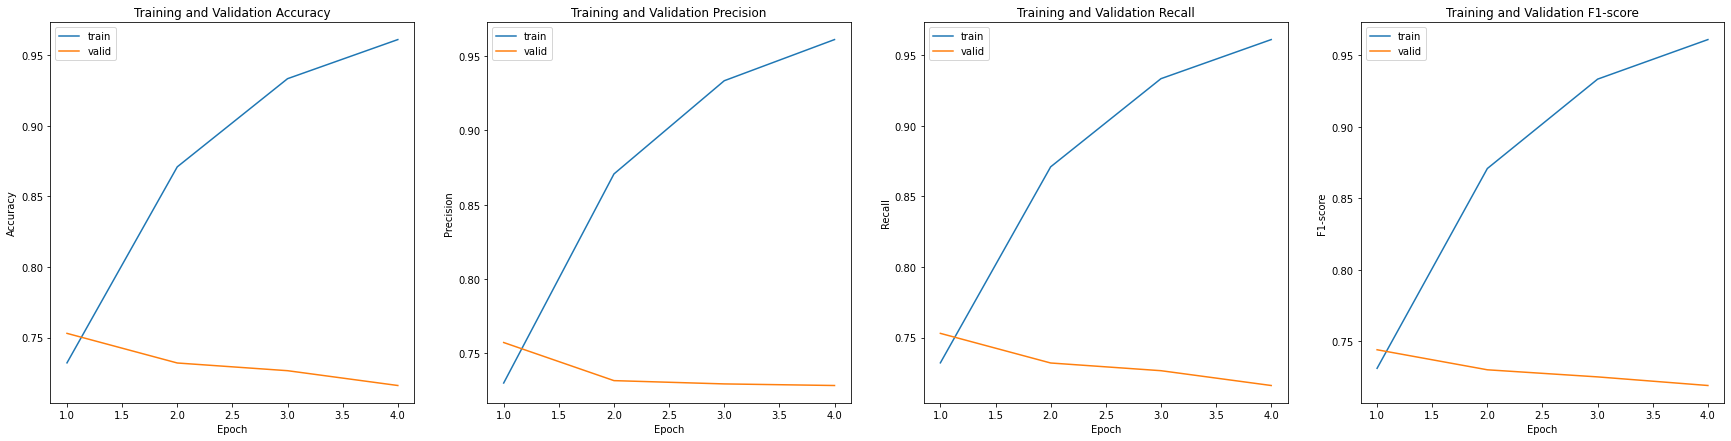

In [56]:
# show line chart
fig, (plt1, plt2, plt3, plt4) = plt.subplots(1, 4, figsize=(30, 7))
epoch = [1,2,3,4]

plt1.plot(epoch, train_acc_lists, label='train')
plt1.plot(epoch, eval_acc_lists, label='valid')
plt1.set_title('Training and Validation Accuracy')
plt1.legend()
plt1.set(xlabel='Epoch', ylabel='Accuracy')

plt2.plot(epoch, train_pre_lists, label='train')
plt2.plot(epoch, eval_pre_lists, label='valid')
plt2.set_title('Training and Validation Precision')
plt2.legend()
plt2.set(xlabel='Epoch', ylabel='Precision')

plt3.plot(epoch, train_rec_lists, label='train')
plt3.plot(epoch, eval_rec_lists, label='valid')
plt3.set_title('Training and Validation Recall')
plt3.legend()
plt3.set(xlabel='Epoch', ylabel='Recall')

plt4.plot(epoch, train_f1_lists, label='train')
plt4.plot(epoch, eval_f1_lists, label='valid')
plt4.set_title('Training and Validation F1-score')
plt4.legend()
plt4.set(xlabel='Epoch', ylabel='F1-score')

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

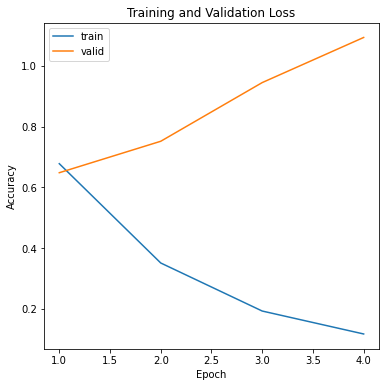

In [57]:
# show line chart
fig, plt1 = plt.subplots(1, 1, figsize=(6, 6))
epoch = [1,2,3,4]

plt1.plot(epoch, train_loss_lists, label='train')
plt1.plot(epoch, eval_loss_lists, label='valid')
plt1.set_title('Training and Validation Loss')
plt1.legend()
plt1.set(xlabel='Epoch', ylabel='Accuracy')

In [58]:
# constructing dataframe from training
df_stats = {'Train Accuracy': np.round(train_acc_lists, 2), 'Train Precision': np.round(train_pre_lists,2), 'Train Recall': np.round(train_rec_lists,2), 'Train F1': np.round(train_f1_lists,2), 'Valid Accuracy': np.round(eval_acc_lists,2), 'Valid Precision': np.round(eval_pre_lists,2), 'Valid Recall': np.round(eval_rec_lists,2), 'Valid F1': np.round(eval_f1_lists,2), 'Train Loss': np.round(train_loss_lists,2), 'Valid Loss': np.round(eval_loss_lists,2)}

# create a dataframe from training
df_stats = pd.DataFrame(data=df_stats)

# rename row index as 'Epoch'
df_stats = df_stats.rename_axis('Epoch')

# display the table
df_stats.index = df_stats.index + 1
df_stats

,Train Accuracy,Train Precision,Train Recall,Train F1,Valid Accuracy,Valid Precision,Valid Recall,Valid F1,Train Loss,Valid Loss
Epoch,,,,,,,,,,
1,0.73,0.73,0.73,0.73,0.75,0.76,0.75,0.74,0.68,0.65
2,0.87,0.87,0.87,0.87,0.73,0.73,0.73,0.73,0.35,0.75
3,0.93,0.93,0.93,0.93,0.73,0.73,0.73,0.72,0.19,0.94
4,0.96,0.96,0.96,0.96,0.72,0.73,0.72,0.72,0.12,1.09


In [59]:
# evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

print('Loading Testing DataLoader...')

pbar = tqdm(testing_loader, leave=True, total=len(testing_loader))
for i, batch_data in enumerate(pbar):
  _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device=device)
  list_hyp += batch_hyp

Loading Testing DataLoader...


100%|██████████| 140/140 [00:10<00:00, 13.55it/s]


## 3.6 Save Prediction

In [60]:
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('prediction.txt', index=False)

print(df)

      index        label
0         0  HS_Moderate
1         1    HS_Strong
2         2      HS_Weak
3         3  HS_Moderate
4         4    HS_Strong
...     ...          ...
2235   2235    HS_Strong
2236   2236    HS_Strong
2237   2237       Non_HS
2238   2238    HS_Strong
2239   2239    HS_Strong

[2240 rows x 2 columns]


## 3.7 Evaluation

In [61]:
prediction = pd.read_csv('prediction.txt')

In [62]:
prediction_list = []

for i in prediction['label'] : 
  if i == 'HS_Weak': 
    prediction_list.append(1)
  elif i == 'HS_Moderate': 
    prediction_list.append(2)
  elif i == 'HS_Strong': 
    prediction_list.append(3)
  else :
    prediction_list.append(0)

In [63]:
data_test = pd.read_csv('dataset_testing.csv')

def label_classification(hs):
  label = ''
  
  if str(hs) == 'HS_Weak':
    label = 1
  elif str(hs) == 'HS_Moderate':
    label = 2
  elif str(hs) == 'HS_Strong':
    label = 3
  else:
    label = 0

  return label

data_test['label'] = data_test['label'].apply(label_classification)

data_test = data_test[['text', 'label']]

data_test.head()

,text,label
0,bro suram kuasa ketiak maya sembunyi dungu ora...,2
1,luwih sing rakyat wakil dewan bubar mbok demo,2
2,campur otak cebong,1
3,monyet alumni murka kampret bani bicara ahok coba,2
4,lengser tirani rezim radikal jokowi tumbang,3


In [64]:
print(f"Accuracy: {round(accuracy_score(data_test['label'], prediction_list), 2)}") 
print(f"Precision: {round(precision_score(data_test['label'], prediction_list, average='macro'), 2)}")
print(f"Recall: {round(recall_score(data_test['label'], prediction_list, average='macro'), 2)}")

Accuracy: 0.73
Precision: 0.75
Recall: 0.73


In [65]:
# micro avg of f1-score
f1_score_micro = f1_score(data_test['label'], prediction_list, average='micro') * 100
print("F1-score (Micro Avg) is {}%." .format(round(f1_score_micro),1))

# macro avg of f1-score
f1_score_macro = f1_score(data_test['label'], prediction_list, average='macro') * 100
print("F1-score (Macro Avg) is {}%." .format(round(f1_score_macro),1))

# weighted avg of f1-score
f1_score_weighted = f1_score(data_test['label'], prediction_list, average='weighted') * 100
print("F1-score (Weighted Avg) is {}%." .format(round(f1_score_weighted),1))

F1-score (Micro Avg) is 73%.
F1-score (Macro Avg) is 73%.
F1-score (Weighted Avg) is 73%.


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       560
           1       0.55      0.73      0.63       560
           2       0.77      0.65      0.71       560
           3       0.83      0.69      0.76       560

    accuracy                           0.73      2240
   macro avg       0.75      0.73      0.73      2240
weighted avg       0.75      0.73      0.73      2240


Confusion Matrix:


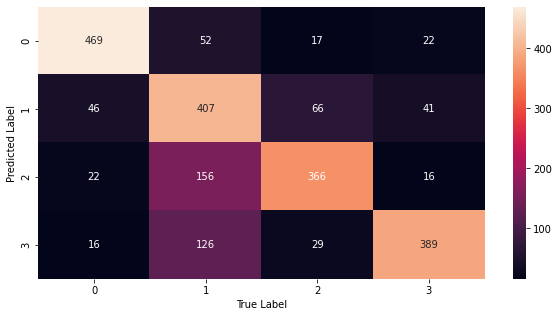

In [66]:
print("Classification Report:")
print(classification_report(data_test['label'], prediction_list))

print("\nConfusion Matrix:")
f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix(data_test['label'], prediction_list), annot=True, fmt=".0f", ax=ax)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

## 3.8 Test Fine-Tuned Model

In [67]:
text = 'kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya
Label: Non_HS (99.766%)


In [68]:
text = 'tukang bully mati aja sana'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: tukang bully mati aja sana
Label: HS_Weak (80.442%)


In [69]:
text = 'antek antek komunis mati sana'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: antek antek komunis mati sana
Label: HS_Weak (80.077%)


In [70]:
text = 'kemaren gue ga di ajak tai emang'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kemaren gue ga di ajak tai emang
Label: HS_Strong (89.499%)


In [71]:
print(logits)

tensor([[-3.5157e+00,  4.4588e-01, -4.3769e-05,  3.0950e+00]], device='cuda:0')


In [72]:
print(torch.topk(logits, 1))

torch.return_types.topk(
values=tensor([[3.0950]], device='cuda:0'),
indices=tensor([[3]], device='cuda:0'))


# **Save Model**

In [73]:
ignore
output_dir = '/content/drive/MyDrive/Skripsi/Code'
# output_dir = '/content/drive/MyDrive/Skripsi/Code/multi-label-hate-speech-detection/models'

# create output directory
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# save a trained model, configuration and tokenizer using 'save_pretrained()'.
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

NameError: ignored

In [ ]:
# save
# with open('/content/drive/MyDrive/Skripsi/Code/multi-label-hate-speech-detection/models/tokenizer.pkl', 'wb') as handle:
with open('/content/drive/MyDrive/Skripsi/Code/tokenizer.pkl', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!ls -l --block-size=K /content/drive/MyDrive/Skripsi/Code
# !ls -l --block-size=K /content/drive/MyDrive/Skripsi/Code/multi-label-hate-speech-detection/models

In [ ]:
amount_of_true_non_hs = 0
amount_of_true_hs_weak = 0
amount_of_true_hs_moderate = 0
amount_of_true_hs_strong = 0

for i in data_test['label'] :
  if i == 1 :
    amount_of_true_hs_weak += 1
  elif i == 2 :
    amount_of_true_hs_moderate += 1
  elif i == 3 :
    amount_of_true_hs_strong += 1
  else :
    amount_of_true_non_hs += 1

print(amount_of_true_non_hs)
print(amount_of_true_hs_weak)
print(amount_of_true_hs_moderate)
print(amount_of_true_hs_strong)

In [ ]:
amount_of_pred_non_hs = 0
amount_of_pred_hs_weak = 0
amount_of_pred_hs_moderate = 0
amount_of_pred_hs_strong = 0

for i in prediction_list :
  if i == 1 :
    amount_of_pred_hs_weak += 1
  elif i == 2 :
    amount_of_pred_hs_moderate += 1
  elif i == 3 :
    amount_of_pred_hs_strong += 1
  else :
    amount_of_pred_non_hs += 1

print(amount_of_pred_non_hs)
print(amount_of_pred_hs_weak)
print(amount_of_pred_hs_moderate)
print(amount_of_pred_hs_strong)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw=dict(aspect="equal"))
labels = 'Non_HS', 'HS_Weak', 'HS_Moderate', 'HS_Strong'
labels = [x.split()[-1] for x in labels]

# true result
sizes = [amount_of_true_non_hs, amount_of_true_hs_weak, amount_of_true_hs_moderate, amount_of_true_hs_strong]
explode = (0.1, 0, 0, 0)

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops=dict(color="white", weight="bold"))
ax1.axis('equal')
ax1.set_title('Labeling True Result')

# prediction result
sizes = [amount_of_pred_non_hs, amount_of_pred_hs_weak, amount_of_pred_hs_moderate, amount_of_pred_hs_strong]
explode = (0.1, 0, 0, 0)

ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops=dict(color="white", weight="bold"))
ax2.axis('equal')
ax2.set_title('Labeling Prediction Result')

# set legend label
ax1.legend(
    labels, title='Label', loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)
)

ax1.plot()
ax2.plot()

# Format Code

**How to Use Black for Jupyter Formatter on Google Colab**

[Run only once, at startup]

*   Connect to your Drive
*   Install black for jupyter with `!pip install black[jupyter]`
*   Restart kernel

[Then]

*   Place your Jupyter Notebook file somewhere on your Drive
*   Anytime you want format your code run: `!black /content/drive/MyDrive/YOUR_PATH/YOUR_NOTEBOOK.ipynb`
*   Don't save your notebook, hit F5 to refresh the page
*   Voila! Now save!

[Reference from here](https://stackoverflow.com/questions/63076002/code-formatter-like-nb-black-for-google-colab)

In [ ]:
# run (uncomment) line below if you want to format your code with black formatter
# !black /content/drive/MyDrive/Skripsi/Code/multi-label-hate-speech-detection/src/multi_label_hs/preprocessing/text_preprocessing.ipynb